# RA Diagnosis Extraction with Machine Learning
This notebook is built for extracting the diagnosis from format-free textfields of Electronic Medical Health records. 
- Feel free to make some adjustments that better correspond with your data

In [282]:
SEED = 26062019

test_size = 0.5 

import sys
from scipy import __version__ as sc_vers
from yellowbrick import __version__ as yb_vers
from sklearn import __version__ as sk_vers
import buildingAClassifier as bc
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
import re
import random
import pickle

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('scipy version:\t\t' + sc_vers)
print('pattern version:\t' + pat_vers)
print('yellowbrick version:\t' + yb_vers)

Current versions Modules:

Pandas version:		0.23.0
Matplotlib version:	2.2.2
numpy version:		1.14.3
sklearn version:	0.21.2
scipy version:		1.1.0
pattern version:	3.6
yellowbrick version:	0.9.1


In [2]:
def binarize(value):
    if value == 'j':
        return 'y'
    elif value == 'n':
        return 'n'
    elif value == 'p':
        return 'n'

radiag_df = pd.read_csv(r'data/annotation_v2_20190125.csv', index_col=0, sep="|", na_values=['NA'])
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x : binarize(x)) 
lemma_radiag_df = radiag_df.copy()
print('Nr of entries:', len(radiag_df))
#radiag_df.head()

Nr of entries: 1361


## Step 1: Cleaning Data

### 1.1 Preprocessing - Word segmentation and lemmatizing 
Applying Natural Language Processing algorithms:
- Word segmentation: words are split on whitespace -> special characters are removed
- lemmatization: words are returned to the root form (if word is in corpus)

In [3]:
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=True))

### 1.2 Balancing classes in data (50% RA cases and 50% non cases)
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 

In [4]:
df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(len(radiag_df[radiag_df['Outcome']=='y']), random_state=SEED)
equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
equal_radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 1.3 Splitting annotated set on both the textual data and the label (Y)

In [394]:
X = equal_radiag_df['XANTWOORD'].values
y = equal_radiag_df[['ID', 'Outcome']].values
y_tot = equal_radiag_df['Outcome'].values
y_b = np.array([bc.binarize(val) for val in y_tot])

### 1.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

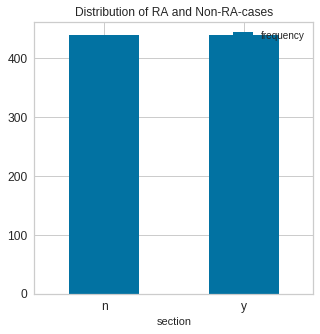

In [6]:
from collections import Counter

labels, values = zip(*Counter(y_tot).items())

df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

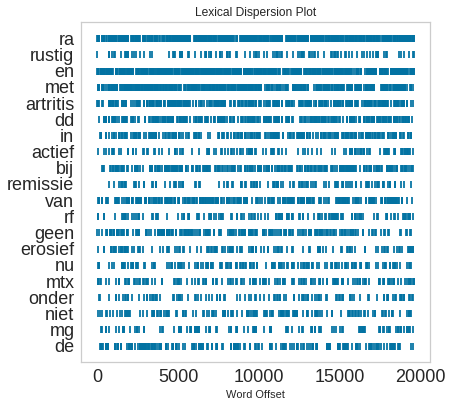

In [8]:
bc.plotLexicalDispersion(X, nr_features=20, n_grams=1)

#### Plot: Feature distribution

<module 'matplotlib.pyplot' from '/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/matplotlib/pyplot.py'>

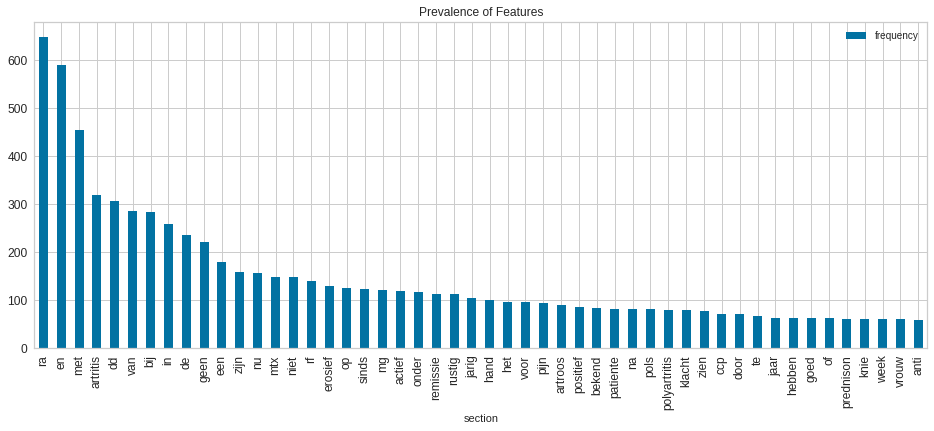

In [459]:
bc.plotSampleDistribution(X, nr_features=50) 

## Step 2: Building the Pipeline

First: Import important modules

In [119]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier


### 2.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [178]:
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 4 - NuSVC probability
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', NuSVC(probability=True,random_state=SEED)),
            ]),
    # Random Forest 5 
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 6
    Pipeline([('vect', TfidfVectorizer()),
                ('clf', DummyClassifier(random_state=SEED)),
            ])
    ]


### 2.2 Initialize the Word Matching Method
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra'. 

In [179]:
l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']
WordMatching = bc.CustomBinaryModel(l_targets)

## Step 3: Compare classification models
Visualize performance of the models in ROC curve

- Note: the ROC curve of the decision tree estimator cant be assessed with the standard plotCrossValidationROC function, because it doesn't calculate the probabilities. Therefore, the function plotBinaryROC is utilized to estimate the decision tree ROC. 

Word Matching 0.7539219616229005 (std : +/-0.01958155283532 )
Decision Tree 0.8344517497403452 (std : +/-0.02073529809788606 )
Train-score Decision Tree 0.994949494949495 (std : +/-4.965068306494546e-17 )
Naive Bayes 0.863115949992258 (std : +/-0.013514723158018032 )
Train-score Naive Bayes 0.982411197655972 (std : +/-0.002093640383473887 )
Gradient Boosting 0.9353230351725896 (std : +/-0.0077556447545790675 )
Train-score Gradient Boosting 0.994949494949495 (std : +/-0.0 )
Neural Networks 0.8945720040038725 (std : +/-0.02359934590673768 )
Train-score Neural Networks 0.9834538171685507 (std : +/-0.024900452230143484 )


/home/tdmaarseveen/.conda/envs/ml_env/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM 0.9001892407634179 (std : +/-0.010712761907465248 )
Train-score SVM 0.9937945415222488 (std : +/-0.0018386034198001713 )
Random Forest 0.8860982709754429 (std : +/-0.010801975365410986 )
Train-score Random Forest 0.994894578013009 (std : +/-0.0001030051595844052 )
Dummy 0.49177325611087247 (std : +/-0.012880743028026694 )
Train-score Dummy 0.49271255731750646 (std : +/-0.0207441205863438 )


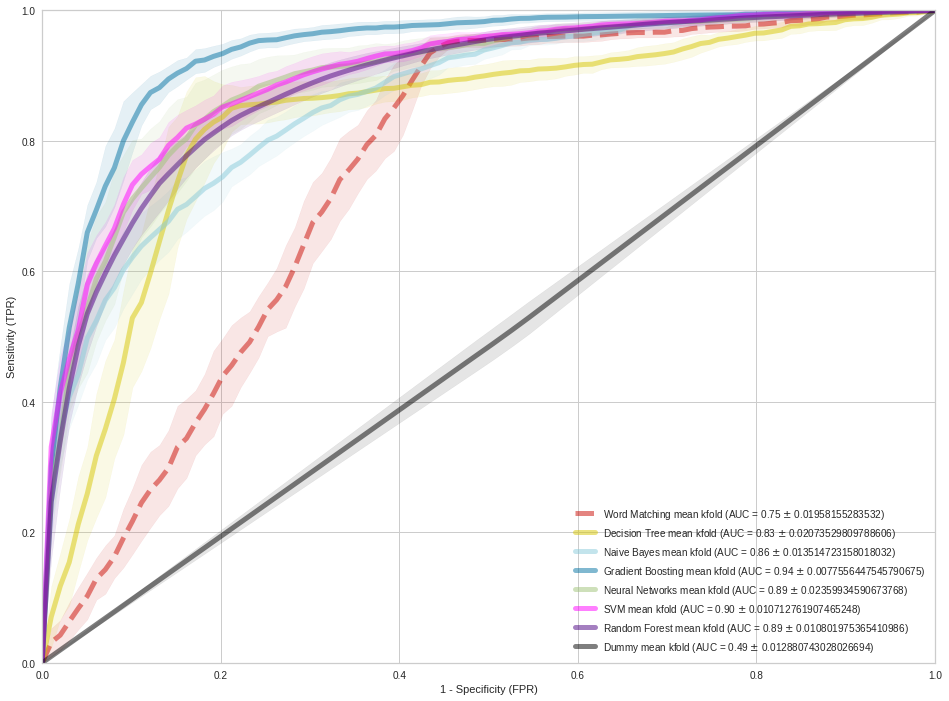

In [445]:
import matplotlib.pyplot as plt

lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM', 'Random Forest', 'Dummy']

l_folds = bc.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:7] # exclude decision -> because it cant assess the probabilities!
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(16,12))

plt, ref_auc, auc_ref, fitted_wm = bc.plotCustomModelROC(WordMatching, X, y_tot, l_folds, 'Word Matching', 'r', '--') # custom made roc
plt, dt_auc, auc_dt, fitted_dt = bc.plotBinaryROC(pipe_list[3], 'Decision Tree', X, y_tot, l_folds, 'y')
plt, d_aucs, fitted_models = bc.plotCrossValidationROC(filtered_pipe,'ROC curve for different classification methods', lbls, X, y_tot, l_folds, ref_auc)
plt.savefig('figures/ROC_curve_all_methods.png', bbox_inches='tight')

### 3.1. Student's T-Test relative to Naive Word Matching

In [185]:
import scipy

for key in d_aucs.keys(): # classifiers with probas
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

# classifiers without probas
print('Decision Tree\t(p =', scipy.stats.ttest_ind(auc_dt, auc_ref)[1], ')')

SVM 	(p = 1.1535697334183318e-13 )
Naive Bayes 	(p = 4.952012056716044e-11 )
Dummy 	(p = 1.1143560900157703e-17 )
Gradient Boosting 	(p = 1.092135965076576e-15 )
Random Forest 	(p = 7.137698159469687e-13 )
Neural Networks 	(p = 5.107334874965387e-11 )
Decision Tree	(p = 1.0537843963980759e-07 )


## Step 4: Distribute Model - save best classification model

In [446]:
best_model = fitted_models['Gradient Boosting'] # median iteration
filename='savedModels/GradientBoostingModel.sav'
pickle.dump(best_model[2], open(filename, 'wb'))

### 4.1 Import best performing model

In [447]:
filename='savedModels/GradientBoostingModel.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Step 5: Evaluate best Model
Determine cut-off

In [448]:
gbm_model = fitted_models['Gradient Boosting']

# Import the fitted model + fold information + the optimal cut_off
estimator = gbm_model[2] # the entire pipeline
classifier = estimator.steps[1] # only the classifier
test_index = gbm_model[3] # use this to get the test set of the k-fold
train_index = gbm_model[4] # use this to get the trainingset of the k-fold
cut_off = gbm_model[5]

# Apply the cut-off on the probabilities -> to assess the predictions
l_pred = [int(gbm_model[0][i] >= cut_off) for i in range(len(gbm_model[0]))]

### 5.1 Evaluate Performance on lower prevalence of RA-cases
#### 5.1.1 ROC curve on 50% RA, 20% RA & 5% RA

GBM 50/50 0.935113621044195 (std : +/-0.007252935170231086 )
GBM .20 0.9342274259092099 (std : +/-0.010839470457101586 )
GBM .05 0.9161971198514345 (std : +/-0.027008906777305327 )


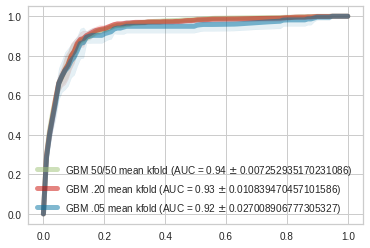

In [461]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 10})
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), 1, 'GBM 50/50', 'g')
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), .4, 'GBM .20', 'r')
plt, mean_auc = bc.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array(y_b), .1, 'GBM .05', 'b')
plt.savefig('figures/results/ROC_GBM_LowPrevalenceRA.png', bbox_inches='tight')

#### 5.1.2 Draw precision Recall Curve on 50% RA, 20% RA & 5% RA
###### Input:
- positive prev = specify the fraction of RA cases

No handles with labels found to put in legend.


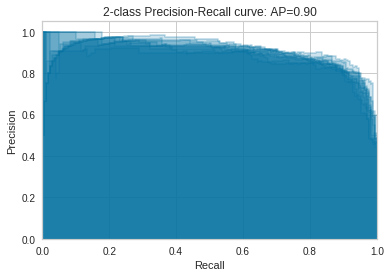

In [186]:
import numpy as np
import importlib
importlib.reload(bc)

positive_prev = .75
clf = filtered_pipe[1] # GBM

bc.plotPrecisionRecall(clf, X, y_b, positive_prev)


### 5.2 Visualize optimal cut-off

       1-fpr       fpr        tf  thresholds       tpr
61  0.883621  0.116379  0.000437    0.651049  0.884058


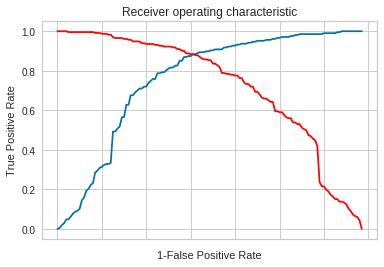

In [79]:
cut_off = bc.optimalCutoff(gbm_model[0], np.array(y_b)[test_index], 'Gradient Boosting', True)

### 5.3 Confusion Matrix 
Visualize proportions of true positives, true negatives, false positives and false negatives

Confusion matrix, without normalization
[[205  27]
 [ 24 183]]


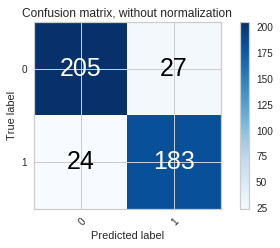

In [187]:
bc.plot_confusion_matrix(np.array(y_b)[test_index], l_pred, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
plt.savefig('figures/results/GBM_confusion_matrix.png', bbox_inches='tight')
plt.show()

### 5.4 Calculate performance characteristics

In [259]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(np.array(y_b)[test_index], l_pred).ravel()
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
accuracy = (tp + tn)/(tp+fn+tn+fp)
ppv,npv = tp/(tp+fp),tn/(tn+fn)
print('Sensitivity: ' + str(sensitivity), '\nSpecificity: ' + str(specificity))
print('PPV: ' +str(ppv), '\nNPV: ' + str(npv))
print('Accuracy: ' +str(accuracy))

Sensitivity: 0.8840579710144928 
Specificity: 0.8836206896551724
PPV: 0.8714285714285714 
NPV: 0.8951965065502183
Accuracy: 0.8838268792710706


### 5.5 Investigate the incorrect predictions
Optional: Which cases where wrongly predicted

In [191]:
predictions = estimator.predict(X[test_index])

for inp, prediction, label in zip(X[test_index], predictions, np.array(y_b)[test_index]):
    if prediction != label:
        print('"', inp, '"\n\n', 'has been classified as ', prediction, 'and should be ', label, '\n') 
print('Cannot print example of output')

Cannot print example of output


## Step 6: Inner workings of the black box 
Optional Visualizations -> of best model & median Fold
### 6.1 Pearson correlation per feature

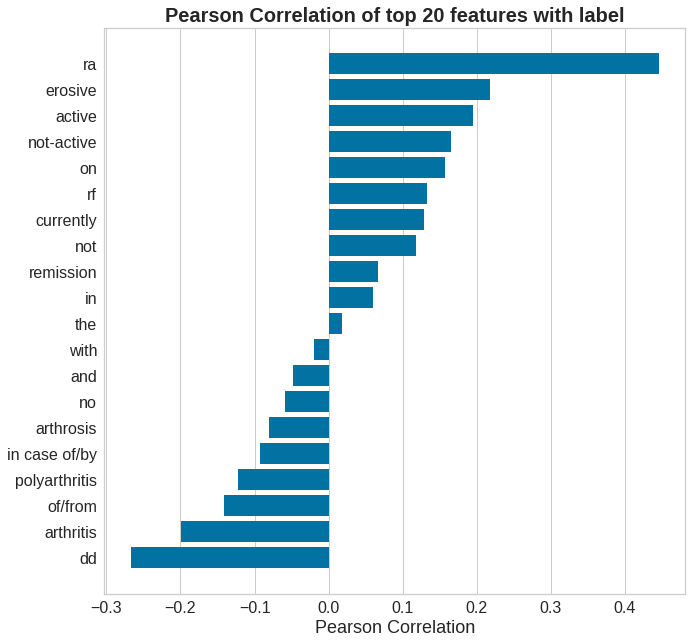

In [262]:
plt = bc.plotFeatureCorrelation(X[train_index], np.array(y_b)[train_index], nr_features=20)
locs, labels = plt.yticks()  

plt.yticks(locs, ['ra', 'erosive', 'active', 'not-active', 'on', 'rf',  'currently', 'not', 'remission', 'in', 'the', 'with', 'and', 'no', 'arthrosis', 'in case of/by', 'polyarthritis', 'of/from', 'arthritis', 'dd'][::-1])
plt.show()

### 6.2 Explained variance per feature
The importance of each feature reflects the model error caused by exclusion of said feature

Andere range? -> komt dit door andere functie? 

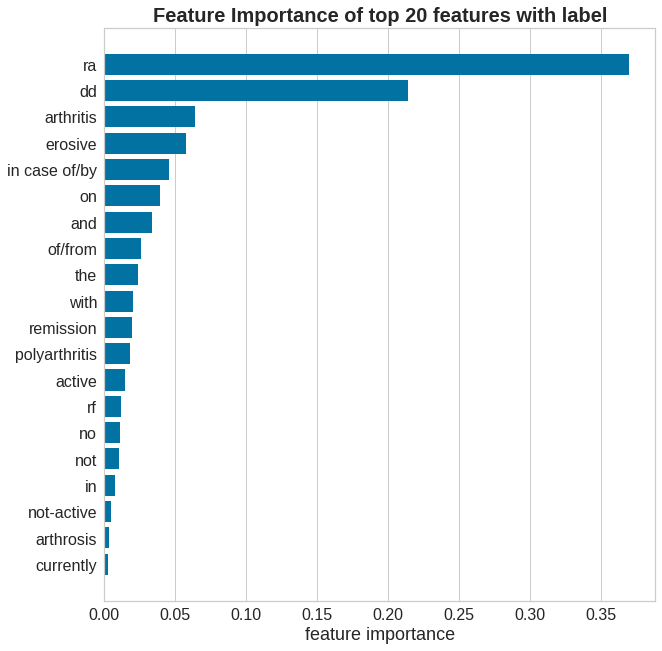

In [401]:
plt = bc.plotFeatureImportance(tuple(clf)[1], X[train_index], np.array(y_b)[train_index], nr_features=20)
locs, labels = plt.yticks()
plt.yticks(locs, ['ra', 'dd', 'arthritis', 'erosive', 'in case of/by', 'on', 'and', 'of/from', 'the', 'with', 'remission', 'polyarthritis',  'active', 'rf', 'no', 'not', 'in', 'not-active', 'arthrosis', 'currently'][::-1])

plt.show()

### 6.3 Trainingset | Lexical Dispersion Plot 

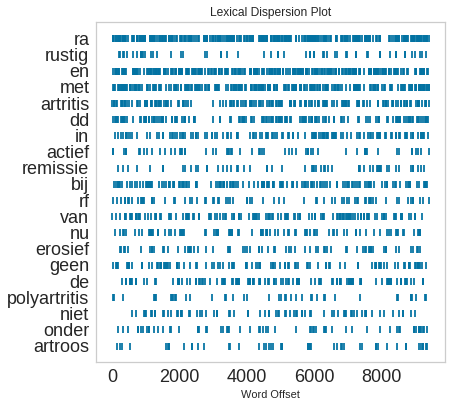

In [264]:
bc.plotLexicalDispersion(X[train_index])

### 6.4 Testset | Lexical Dispersion Plot 

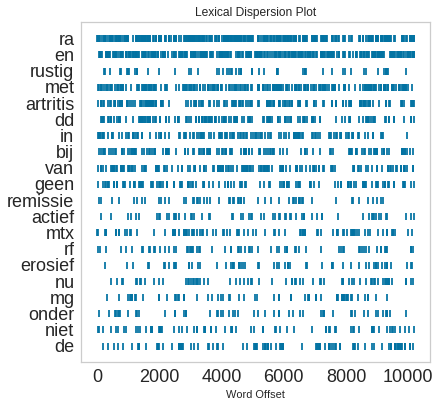

In [21]:
bc.plotLexicalDispersion(X[test_index])

### 6.5 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

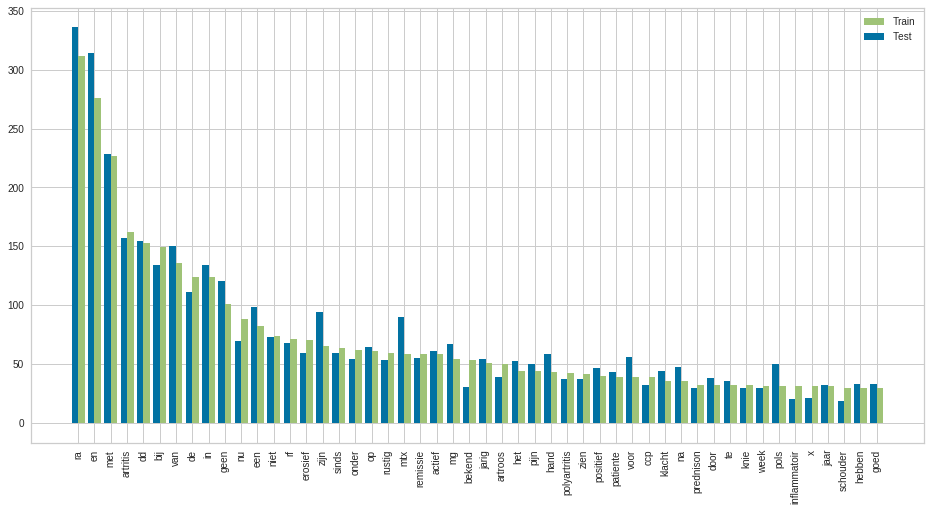

In [460]:
import matplotlib.pyplot as plt

# Assess most prevalent features
bc.plotTrainTestDistribution(X[train_index], X[test_index], nr_features=50) 

### 6.6 Graphviz | Write GBM structure to 
Outputs a file that can be visualized in http://viz-js.com/ 
##### Input:
- sub_tree = specify the subtree to draw (0-99 in this case)

In [454]:
import os 
import importlib
importlib.reload(bc)

sub_tree = 99

test_clf = tuple(classifier)[1] # get classifier
tree2 = test_clf.estimators_[sub_tree, 0] 
lbls = tuple(estimator.steps[0])[1].get_feature_names()
bc.exportTreeGraphViz(X[train_index], tree2, lbls, 'GBM_structure_subtree' + str(sub_tree))